# Combo Modeling
An introduction to the native ensemble/combo model in scalecast.  

In [1]:
import pandas as pd
import pandas_datareader as pdr
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta
from scalecast.Forecaster import Forecaster

Download data from FRED (https://fred.stlouisfed.org/series/HOUSTNSA). This data is interesting due to its strong seasonality and irregular cycles. It measures monthly housing starts in the USA since 1959. Predicting this metric with some series that measures demand for houses could be an interesting extension to be able to explain housing prices.

We also bring in the recession indicator from FRED ('JHDUSRGDPBR') because it is theoretically an important external regressor.

In [2]:
df = pdr.get_data_fred(['HOUSTNSA','JHDUSRGDPBR'],start='1900-01-01',end='2021-12-31')
df['JHDUSRGDPBR'] = df['JHDUSRGDPBR'].fillna(method='ffill').fillna(0)
f = Forecaster(y=df['HOUSTNSA'],current_dates=df.index)
f

Forecaster(
    DateStartActuals=1959-01-01T00:00:00.000000000
    DateEndActuals=2021-12-01T00:00:00.000000000
    Freq=MS
    N_actuals=756
    ForecastLength=0
    Xvars=[]
    Differenced=0
    TestLength=1
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
    GridsFile=Grids
)

## EDA

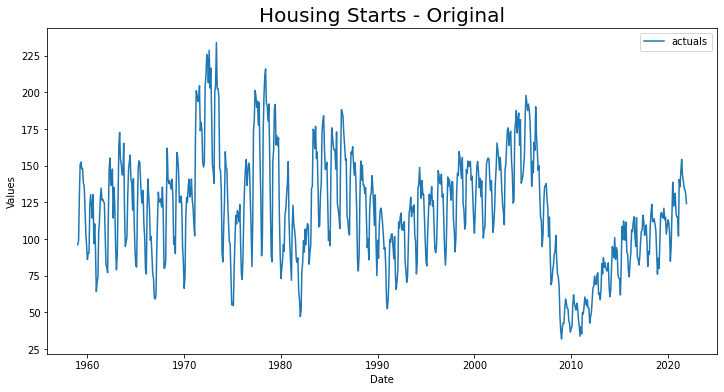

In [3]:
f.plot()
plt.title('Housing Starts - Original',size=20)
plt.show()

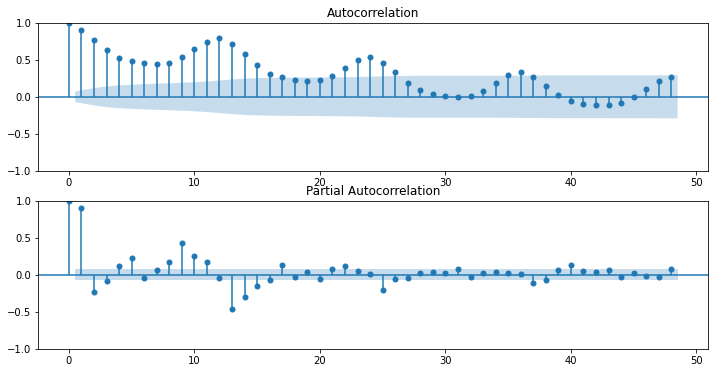

In [32]:
figs, axs = plt.subplots(2, 1,figsize=(12,6))
f.plot_acf(ax=axs[0],lags=48)
f.plot_pacf(ax=axs[1],lags=48)
plt.show()

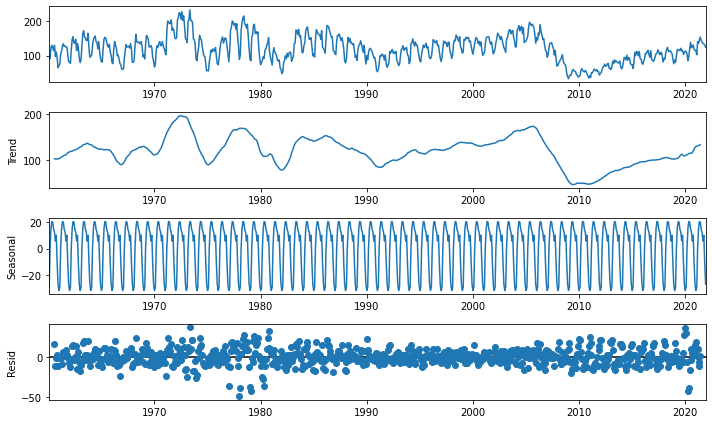

In [33]:
plt.rc("figure",figsize=(10,6))
f.seasonal_decompose().plot()
plt.show()

In [6]:
critical_pval = 0.05
print('-'*100)
print('Augmented Dickey-Fuller results:')
stat, pval, _, _, _, _ = f.adf_test(full_res=True)
print('the test-stat value is: {:.2f}'.format(stat))
print('the p-value is {:.4f}'.format(pval))
print('the series is {}'.format('stationary' if pval < critical_pval else 'not stationary'))
print('-'*100)

----------------------------------------------------------------------------------------------------
Augmented Dickey-Fuller results:
the test-stat value is: -4.11
the p-value is 0.0009
the series is stationary
----------------------------------------------------------------------------------------------------


## Prepare Forecast

### Prepare the Recession Indicator
- use as an exogenous regressor

In [7]:
df.head()

,HOUSTNSA,JHDUSRGDPBR
DATE,,
1959-01-01,96.2,0.0
1959-02-01,99.0,0.0
1959-03-01,127.7,0.0
1959-04-01,150.8,0.0
1959-05-01,152.5,0.0


In [8]:
# prepare recession indicator for future
# assume no future recessions in next two years
recessions = df.reset_index()[['DATE','JHDUSRGDPBR']]
fut_recessions = pd.DataFrame({'DATE':pd.date_range(start=recessions['DATE'].max(),end=recessions['DATE'].max() + relativedelta(months=24),freq='MS').values[1:],
                              'JHDUSRGDPBR':[0]*24})
recessions = pd.concat([recessions,fut_recessions])
recessions.tail()

,DATE,JHDUSRGDPBR
19,2023-08-01,0.0
20,2023-09-01,0.0
21,2023-10-01,0.0
22,2023-11-01,0.0
23,2023-12-01,0.0


### Load Object with Parameters and Regressors
- Forecast length: 24 periods (two years)
- Test length (10%)
- Monthly seasonality with wave functions
- Days in month with dummy variables
- 3 lags
- 3 seasonal lags (separated by 12 months)
- External recession indicator
- Recession indicator lag_1
- Recession indicator lag_12
- 1,000 bootstrap samples for more accurate confidence intervals

In [9]:
f.generate_future_dates(24)
f.set_test_length(.1)
f.add_seasonal_regressors('month',raw=False,sincos=True)
f.add_seasonal_regressors('daysinmonth',raw=False,dummy=True,drop_first=True)
f.add_ar_terms(3)
f.add_AR_terms((3,12))
f.ingest_Xvars_df(recessions,date_col="DATE")
f.add_lagged_terms('JHDUSRGDPBR')
f.add_lagged_terms('JHDUSRGDPBR',lags=12,upto=False)
f.set_bootstrap_samples(1000)
f

Forecaster(
    DateStartActuals=1960-02-01T00:00:00.000000000
    DateEndActuals=2021-12-01T00:00:00.000000000
    Freq=MS
    N_actuals=743
    ForecastLength=24
    Xvars=['monthsin', 'monthcos', 'daysinmonth_29', 'daysinmonth_30', 'daysinmonth_31', 'AR1', 'AR2', 'AR3', 'AR12', 'AR24', 'AR36', 'JHDUSRGDPBR', 'JHDUSRGDPBRlag_1', 'JHDUSRGDPBRlag_12']
    Differenced=0
    TestLength=75
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=1000
    CurrentEstimator=None
    GridsFile=Grids
)

## Apply Exponential Smoothing Model

In [10]:
f.set_estimator('hwes')
f.manual_forecast(trend='add',seasonal='add')

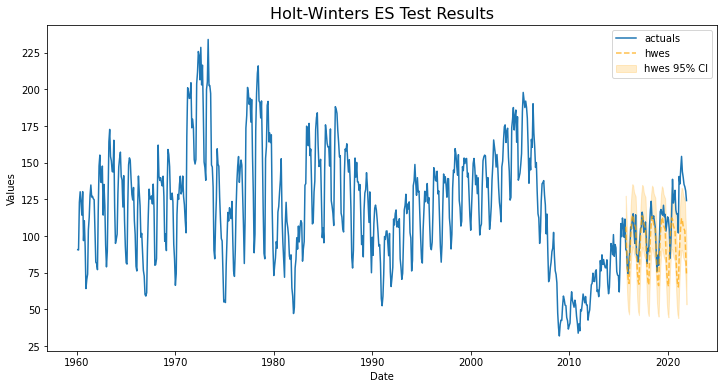

In [11]:
f.plot_test_set(ci=True)
plt.title('Holt-Winters ES Test Results',size=16)
plt.show()

## Apply ARIMA Model

In [12]:
f.set_estimator('arima')
f.manual_forecast(order=(3,1,3),seasonal_order=(2,1,2,12),Xvars=['JHDUSRGDPBR'])

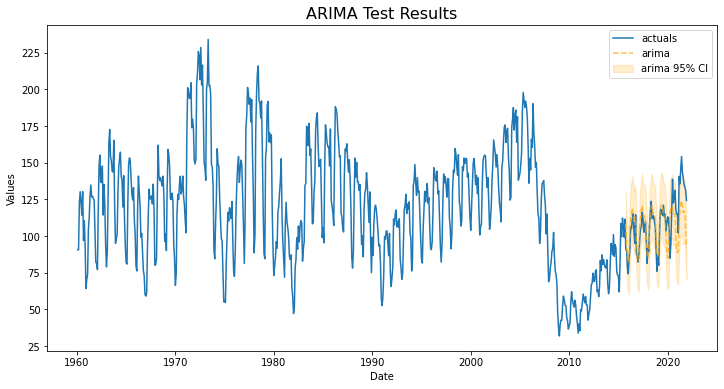

In [13]:
f.plot_test_set(ci=True,models='arima')
plt.title('ARIMA Test Results',size=16)
plt.show()

## Apply MLR Model

In [14]:
f.set_estimator('mlr')
f.manual_forecast()

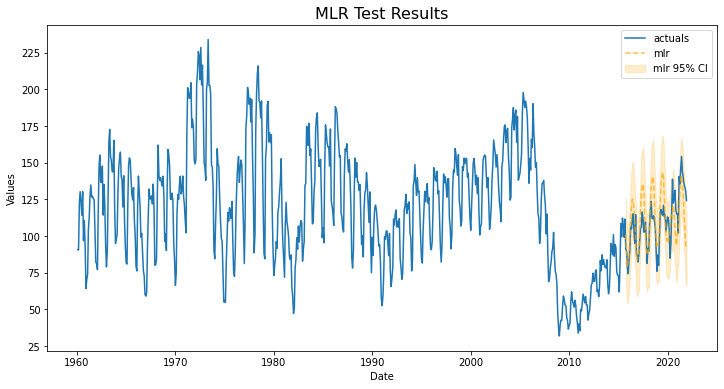

In [15]:
f.plot_test_set(ci=True,models='mlr')
plt.title('MLR Test Results',size=16)
plt.show()

The HWES and ARIMA model underforecasted a few periods at the end of the test set. MLR was a little better, but it overforecasted some periods at the beginning. Maybe by combining models we can get a better results?

## Apply Combination Model

### Simple Average

The simplest way to combination model is to add a simple average of all models, which is the default mode.

In [16]:
f.set_estimator('combo')
f.manual_forecast(call_me='simple_avg')

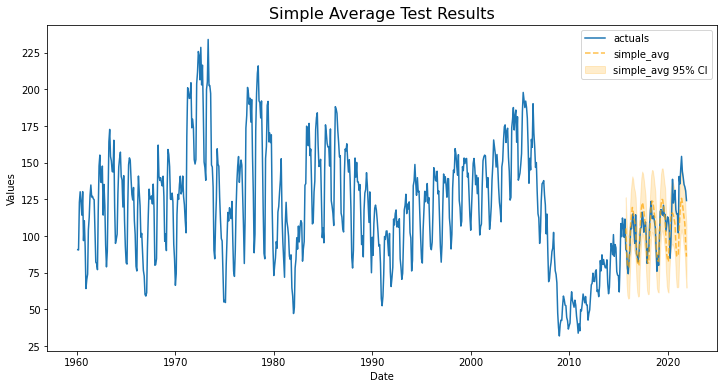

In [17]:
f.plot_test_set(ci=True,models='simple_avg')
plt.title('Simple Average Test Results',size=16)
plt.show()

The periods at the beginning look pretty good this way, but the periods at the end are still underforecast. Adding weights to the models could help this.

### Manual Weighted Average

Let's give twice as much weight to MLR as either of the other two models. I pass the list of models to combine in the `models` arg and the weights in an array of equal length in the `weights` arg. I don't need to use list and tuple, but chose to do so here because it felt right. The orders of these arrays will be aligned to one another (first model in `models` gets first weight in `weights`, etc.). A peculiarity of this model is that when passing weights this way, you need to set `determine_best_by` to `None`. In the `weights` arg, I could set weights so that they add to 1 `(.5,.25,.25)` or I could do as below and the algorithm will rebalance them for me.

In [18]:
f.manual_forecast(how='weighted',determine_best_by=None,models=['mlr','arima','hwes'],weights=(2,1,1),call_me='manual_weighted_avg')

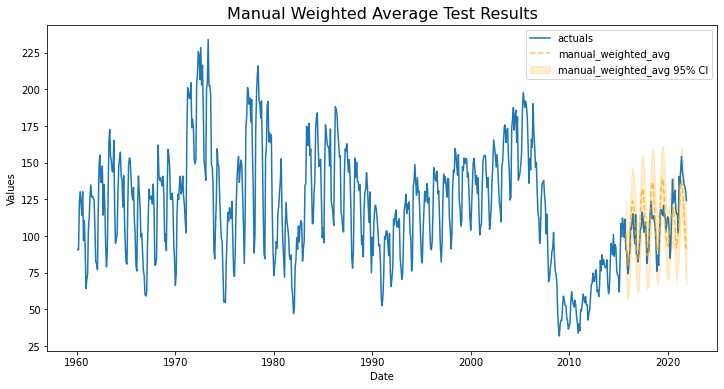

In [19]:
f.plot_test_set(ci=True,models='manual_weighted_avg')
plt.title('Manual Weighted Average Test Results',size=16)
plt.show()

This looks potentially better. Let's try to give the model the ability to assign its own weights based on each model's in-sample R2 score, hoping no models overfit so they don't have an outsized weight.

### Automatic Weighted Average with In-sample Metric

In [20]:
f.manual_forecast(how='weighted',models=['mlr','arima','hwes'],determine_best_by='InSampleR2',call_me='weighted_avg_insampler2')

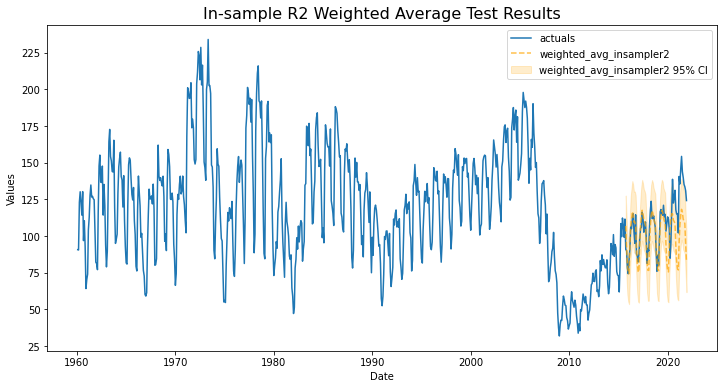

In [21]:
f.plot_test_set(ci=True,models='weighted_avg_insampler2')
plt.title('In-sample R2 Weighted Average Test Results',size=16)
plt.show()

Let's see what weights were selected.

In [22]:
model_weights = f.export('model_summaries',models='weighted_avg_insampler2')[['models','weights']]
print('the models used in the last combo were: {}'.format(*model_weights['models']))
print('their assigned weights were: {}'.format([round(i,2) for i in model_weights['weights'].values[0]]))

the models used in the last combo were: ['hwes', 'arima', 'mlr']
their assigned weights were: [0.55, 0.4, 0.05]


The MLR apparently had a much worse in-sample R2 than the other models, so it was assigned less weight. Let's try again with a test-set metric: RMSE.  

### Automatic Weighted Average with Test-set Metric

In [23]:
f.manual_forecast(how='weighted',models=['mlr','arima','hwes'],determine_best_by='TestSetRMSE',call_me='weighted_avg_testrmse')

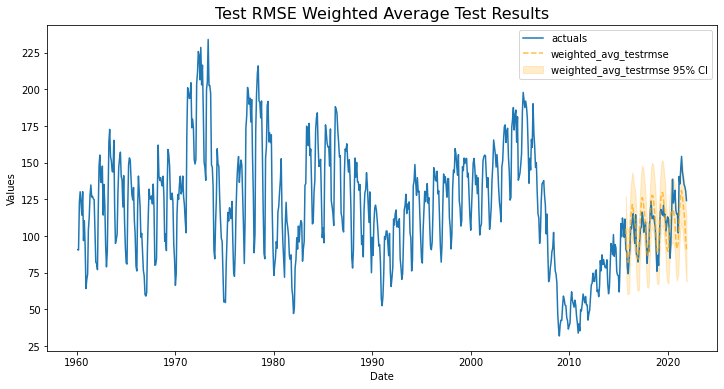

In [24]:
f.plot_test_set(ci=True,models='weighted_avg_testrmse')
plt.title('Test RMSE Weighted Average Test Results',size=16)
plt.show()

In [25]:
model_weights = f.export('model_summaries',models='weighted_avg_testrmse')[['models','weights']]
print('the models used in the last combo were: {}'.format(*model_weights['models']))
print('their assigned weights were: {}'.format([round(i,2) for i in model_weights['weights'].values[0]]))

the models used in the last combo were: ['arima', 'mlr', 'hwes']
their assigned weights were: [0.51, 0.44, 0.05]


This time, the HWES was significantly less weighted than the MLR, suggesting the HWES model may be overfit. We will explore that more later.  

When assigning weights automatically, it is easy to overfit by selecting a test-set metric to do this with. A more sound way is to use ValidationMetricValue, which is the default metric selected, but only works when all models have been tuned (a process we did not cover here). It selects weights based on performance on a separate out-of-sample slice of the data. When the model is then tested on the test set, it's less likely to overfit.  

We only examined two possible metrics in the weighted average process, but the following are also available:

In [26]:
from scalecast.Forecaster import _determine_best_by_
print(*_determine_best_by_,sep='\n')

TestSetRMSE
TestSetMAPE
TestSetMAE
TestSetR2
InSampleRMSE
InSampleMAPE
InSampleMAE
InSampleR2
ValidationMetricValue
LevelTestSetRMSE
LevelTestSetMAPE
LevelTestSetMAE
LevelTestSetR2


### Splice

Let's see how all these models did in our forecasting horizon, and if their predictions look believable. We will sort the models so they are displayed from best-to-worst in terms of how they performed on the test set, using RMSE as the metric.

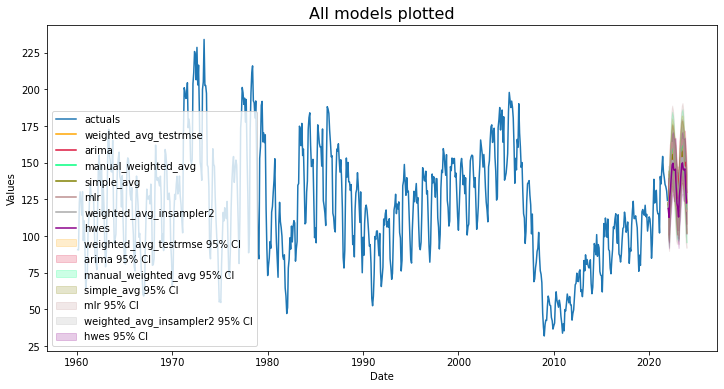

In [27]:
f.plot(order_by='TestSetRMSE',ci=True)
plt.title('All models plotted',size=16)
plt.show()

Unsurprisingly, the model that was optimized by weighting the other models based on their test-set performance had the best test-set performance. So take its results with a grain of salt. The ARIMA model was second best, followed by the weighted average with the weights set manually.   

Since it's hard to differentiate all these models, let's look at the top-3 only and display without confidence intervals.  

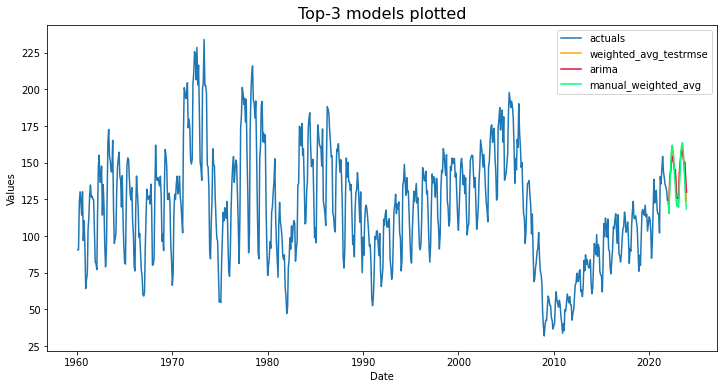

In [28]:
f.plot(order_by='TestSetRMSE',ci=False,models='top_3')
plt.title('Top-3 models plotted',size=16)
plt.show()

Nice! Maybe I have reason to believe that the manual weighted avg model will do better in the first year and the ARIMA in the second. If that is the case, I can splice them together like so:

In [29]:
f.manual_forecast(how='splice',splice_points=['2023-01-01'],models=['manual_weighted_avg','arima'],call_me='splice')

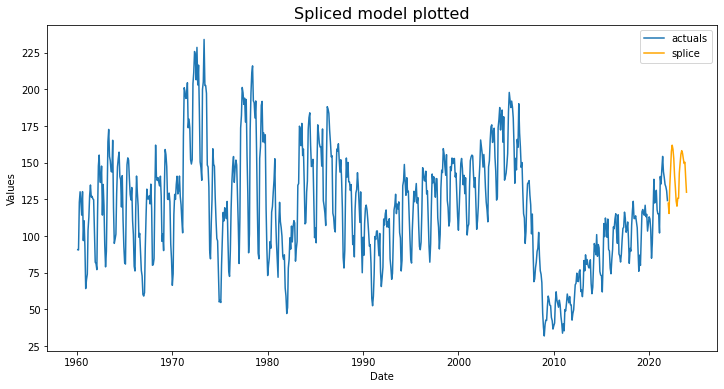

In [30]:
f.plot(models='splice')
plt.title('Spliced model plotted',size=16)
plt.show()

## Wrapping Up

Voila! To finish up, let's export some interesting model summaries for each of these models.

In [31]:
pd.set_option('display.float_format',  '{:.4f}'.format)
ms = f.export('model_summaries',determine_best_by='TestSetRMSE')
ms[
    [
        'ModelNickname',
        'TestSetRMSE',
        'TestSetR2',
        'InSampleRMSE',
        'InSampleR2',
        'models',
        'best_model'
    ]
]

,ModelNickname,TestSetRMSE,TestSetR2,InSampleRMSE,InSampleR2,models,best_model
0,splice,13.7492,0.4087,10.5010,0.9256,"[manual_weighted_avg, arima]",True
1,weighted_avg_testrmse,13.7860,0.4055,10.5312,0.9252,"[arima, mlr, hwes]",False
2,arima,14.0133,0.3857,11.3946,0.9107,None,False
3,manual_weighted_avg,14.7269,0.3216,11.9050,0.9044,"[mlr, arima, hwes]",False
4,simple_avg,15.2145,0.2759,10.3969,0.9271,"[hwes, arima, mlr]",False
5,mlr,15.2644,0.2711,12.6949,0.8913,None,False
6,weighted_avg_insampler2,17.4944,0.0426,10.5167,0.9254,"[hwes, arima, mlr]",False
7,hwes,22.0323,-0.5185,10.8571,0.9190,None,False


Out of our three original models, ARIMA and MLR did the best and as expected, HWES is overfit. Our combo models generally did very well!  

Interestingly, the spliced model returned the best metrics for us, but how were its metrics determined? Well, since there is no way to backcast a spliced model, its test-set predictions and fitted values, which all these metrics are calculated off of, are set as the average of all models passed in the splice. So again, take its results with a grain of salt.  

This concludes our look at combo models. Keep in mind, you can get really creative with this process. Combos of combos are available, a lot more models can be considered when combining, and tuning models helps reduce overfitting in this process.